In [14]:
library(ncdf4)
library(viridis)
library(fields)
library(rstan)
options(mc.cores = parallel::detectCores())

In [18]:
setwd('d:/dropbox/working/bayesian_matrix_model/Bayesian-matrixmodel/')

In [19]:
nc <- nc_open('data/SeaFlow_SizeDist_regrid-15-5.nc')

In [20]:
data              <- list()
data$w_obs        <- ncvar_get(nc,'w_obs')
data$PAR          <- ncvar_get(nc,'PAR')
data$m            <- ncvar_get(nc,'m')
data$delta_v_inv  <- ncvar_get(nc,'delta_v_inv')
data$v_min        <- ncvar_get(nc,'v_min')
data$time         <- ncvar_get(nc,'time')
data$dt           <- 15
data$nt           <- 1440/data$dt
data$nt_obs       <- length(data$time)
data$return_prior <- 0
data$obs          <- t(data$w_obs)
data$t_obs        <- data$time

delta_v <- 1/data$delta_v_inv
v       <- data$v_min*2^(0:14*delta_v)

Interpolate missing values - we can do this more accurately than what is implemented

In [21]:
t_int <- seq(0,tail(data$time,1),3)
data$OBS <- matrix(NA,nrow=15,ncol=length(t_int))

for(i in 1:data$m){
    data$OBS[i,] <- approx(data$t_obs,data$obs[i,],xout=t_int)$y
}
data$obs   <- data$OBS
data$t_obs <- t_int

In [22]:
stride_t_obs     <- 15

DATA <- list()
for(i in 0:3){
    ind       <- data$t_obs > i*1440 & data$t_obs < (i+1)*1440 
    tmp       <- data
    tmp$t_obs <- data$t_obs[ind]
    tmp$obs   <- data$obs[,ind]
    tmp$E     <- approx(data$time,data$PAR,xout=seq(min(tmp$t_obs),max(tmp$t_obs),length.out=tmp$nt))$y

    if(stride_t_obs > 0){
        tmp$t_obs <- tmp$t_obs[seq(1,length(tmp$t_obs),stride_t_obs)]
        tmp$obs   <- tmp$obs[,seq(1,ncol(tmp$obs),stride_t_obs)]
    }
    tmp$nt_obs <- dim(tmp$obs)[2]

    DATA[[i+1]] <- tmp
}

In [23]:
mod_static     <- stan_model('sequential/stan_static.stan')

In [24]:
mod_sequential <- stan_model('sequential/stan_sequential.stan')

In [25]:
MCMC=POST <- list()

##--FIRST DAY--###################
dat       <- DATA[[1]]
dat$w_ini <- data$w_obs[1,]
MCMC[[1]] <- sampling(mod_static,data=dat,open_progress=TRUE)
	POST[[1]] <- extract(MCMC[[1]])

Warning message:
"There were 3250 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess"Warning message:
"Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess"

In [26]:
##--SUCCESSIVE DAYS--###################
for(i in 2:length(DATA)){
	dat       <- DATA[[i]]
	dat$t_obs <- DATA[[1]]$t_obs
	
	dat$w_ini   <- apply(POST[[i-1]]$mod_obspos,c(2,3),mean)[,dim(POST[[i-1]]$mod_obspos)[3]]
	dat$theta_t <- c(mean(POST[[i-1]]$b),         sd(POST[[i-1]]$b),
   				     mean(POST[[i-1]]$delta_max), sd(POST[[i-1]]$delta_max),
				     mean(POST[[i-1]]$gamma_max), sd(POST[[i-1]]$gamma_max),
				     mean(POST[[i-1]]$E_star),    sd(POST[[i-1]]$E_star))

	MCMC[[i]] <- sampling(mod_sequential,data=dat,open_progress=TRUE)
	POST[[i]] <- extract(MCMC[[i]])
}

[1] 2
[1] 3
[1] 4


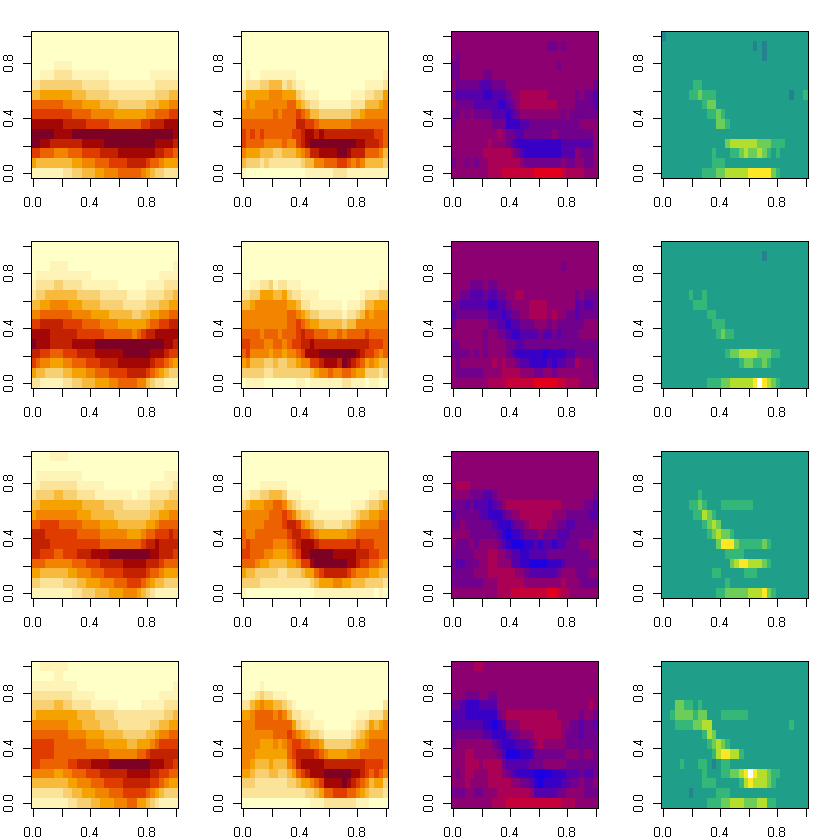

In [34]:
cols <- colorRampPalette(c('blue','red'))

par(mfrow=c(4,4),mar=c(2,2,2,2))
for(i in 1:length(DATA)){
	mu <- t(apply(POST[[i]]$mod_obspos,c(2,3),mean))
	image(mu); box()
	image(t(DATA[[i]]$obs)); box()
	image(mu - t(DATA[[i]]$obs),zlim=c(-0.1,0.1),col=cols(10)); box()
		#image.plot(matrix(c(-0.1,0.1)),legend.only=TRUE,col=cols(10),side=3,line=-1)
	image((mu - t(DATA[[i]]$obs))^2,col=viridis(10),zlim=c(-5E-3,5E-3)); box()
}

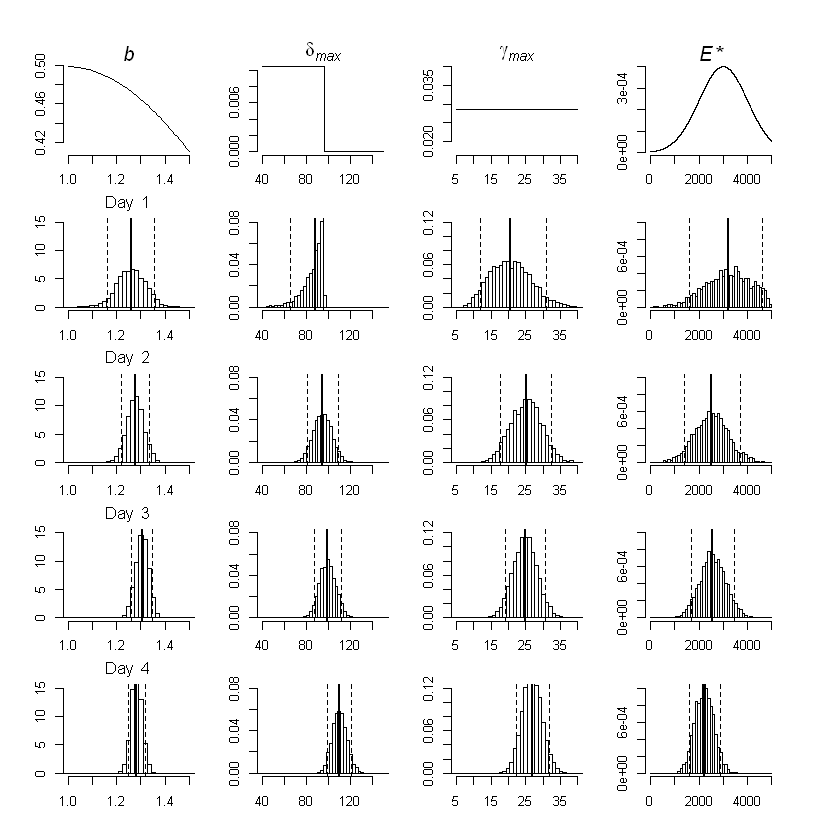

In [38]:
par(mfrow=c(5,4),mar=c(2,2,2,2),oma=c(2,2,2,2))
plot(seq(1,1.5,0.01),dnorm(seq(1,1.5,0.01),mean=1,sd=0.8),type='l',bty='n')
	mtext(expression(italic(b)))
plot(seq(40,150,0.1),dunif(seq(40,150,0.1),0,96),type='l',bty='n')
	mtext(expression(italic(delta['max'])))
plot(seq(5,40,0.1),dunif(seq(5,40,0.1),5,40),type='l',bty='n')
	mtext(expression(italic(gamma['max'])))
plot(seq(0,5000,1),dnorm(seq(0,5000,1),mean=3000,sd=1000),type='l',bty='n')
	mtext(expression(italic(E*'*')))

for(i in 1:length(DATA)){
	hist(POST[[i]]$b,main='',xlim=c(1,1.5),breaks=seq(0.5,2,length.out=90),freq=FALSE,ylim=c(0,15))
		abline(v=quantile(POST[[i]]$b,probs=c(0.05,0.5,0.95)),lty=c(2,1,2),lwd=c(1,2,1))
        mtext(paste('Day ',i),cex=0.8,line=0.5)
	hist(POST[[i]]$delta_max,main='',xlim=c(40,150),breaks=seq(20,200,length.out=70),freq=FALSE,ylim=c(0,0.08))
		abline(v=quantile(POST[[i]]$delta_max,probs=c(0.05,0.5,0.95)),lty=c(2,1,2),lwd=c(1,2,1))
	hist(POST[[i]]$gamma_max,main='',xlim=c(5,40),breaks=seq(0,50,length.out=50),freq=FALSE,ylim=c(0,0.12))
		abline(v=quantile(POST[[i]]$gamma_max,probs=c(0.05,0.5,0.95)),lty=c(2,1,2),lwd=c(1,2,1))
	hist(POST[[i]]$E_star,main='',xlim=c(0,5000),breaks=seq(0,5000,length.out=50),freq=FALSE,ylim=c(0,0.001))
		abline(v=quantile(POST[[i]]$E_star,probs=c(0.05,0.5,0.95)),lty=c(2,1,2),lwd=c(1,2,1))
}